In [35]:
# FILE: AmplitudeDecayRate.ipynb
# AUTHOR: NOAH J COWAN
# LICENSE: MIT


# FIRST BLOCK CONTAINS ALL THE NEEDED FUNCTIONS

# import numpy for math,AudioSegment for importing audio, matplotlib for plotting
import numpy as np
from matplotlib import pyplot as plt 
from scipy.signal import hilbert, chirp, butter, filtfilt
from pydub import AudioSegment
# For fitting an expontial decay from the envelope data we need "curve_fit"
from scipy.optimize import curve_fit
from IPython.display import Audio



# Define a function that simply loads a two-channel soundwave and takes returns each channel
def loadsoundwave(filename,channel):

    # Load the audio file
    sound = AudioSegment.from_file(filename)

    y = np.array(sound.get_array_of_samples())
    y = y.reshape((-1,sound.channels)) # the two sound channels are interlaced
    y = y[:,channel] # grab just the channel requested

    fs = sound.frame_rate
    N = int(sound.frame_count())
    t = np.arange(N)/fs

    return t,y,fs


# Define a function that uses a rectifier and low-pass filter to estimate signal envelope
# Note that the hilbert transform method does not work well!
def extract_envelope(signal, fs, cutoff_freq, Nnorm):
    """Rectifies and low-pass filters an auditory signal."""
    # we will use indices > Nnorm for normalizing the envelope

    # Rectify the signal
    rectified_signal = np.abs(signal)

    # Design the low-pass filter
    nyquist_freq = 0.5 * fs
    cutoff_freq = 2  
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(4, normalized_cutoff, btype='low')

    # Apply the filter
    sigfilt = filtfilt(b, a, rectified_signal)
    envelope = (np.max(np.abs(signal[Nnorm:]))/np.max(sigfilt[Nnorm:]))*sigfilt
    
    return envelope


# Define an exponential decay function; tau is the time constant
def exponential_decay(x, a, tau, c):
    return a * np.exp(-x/tau) + c

In [37]:
# Pick a file; replace soundfile.wav with the name of your m4a file
# If you need to use a wav file, you will need a different audio input mechanism
# or you can use ffmpeg to convert to m4a

trial = "soundfile.m4a"

t,y,fs = loadsoundwave(trial,0)

Audio(y, rate=fs)

Fitted parameters: a = 6106.27, tau = 1.14, c = 457.60


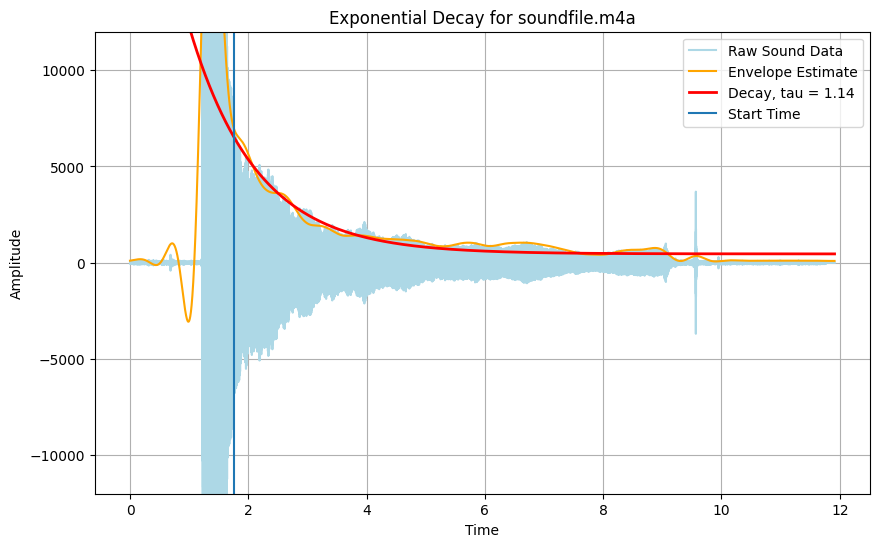

In [38]:
    

# Note! Here you may want to play around with the "start time"
# I recommend adjusting the start time by trial and error to be a bit after the sound starts
    
tstart = 1.75 # in seconds
Nstart = round(tstart*fs) # starting index 


# Estimate the envelope:
cutoff = 5 # this is the cut-off frequency of the envelope detector in Hz
yenvelope = extract_envelope(y, fs, cutoff, Nstart)


# Fit the envelope data using curve_fit from Nstart to the end
initial_guess = [np.max(y), 3, 0]  # Initial guesses for a, b, and c
params, covariance = curve_fit(exponential_decay, t[Nstart:]-tstart, yenvelope[Nstart:], p0=initial_guess)
a_fit, tau_fit, c_fit = params # Extract the fitted parameters

print(f"Fitted parameters: a = {a_fit:.2f}, tau = {tau_fit:.2f}, c = {c_fit:.2f}")
    

# Finally, plot the original data, envelope, and fitted curve
plt.figure(figsize=(10, 6))
plt.plot(t, y, label="Raw Sound Data", color="lightblue")
plt.plot(t, -y, color="lightblue") # a trick to make it look symmetric
plt.plot(t, yenvelope, label="Envelope Estimate", color="orange")
plt.plot(t, exponential_decay(t-tstart, *params), label="Decay, tau = " + f"{tau_fit:.2f}", color="red", linewidth=2)

YLIM = 12000
plt.ylim(-YLIM,YLIM)
plt.plot([tstart,tstart],[-YLIM,YLIM], label="Start Time")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Exponential Decay for " + trial)
plt.grid()
plt.show()